<a href="https://colab.research.google.com/github/JayPBhatia/MastersProject/blob/main/AutoTS_EPIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
#from google.colab import drive
#drive.mount('/content/gdrive/')
#path = 'gdrive/MyDrive/ColabOutput/'

path = './'

In [2]:
!pip install autots

In [3]:
pip install autots['additional']

In [ ]:
!pip install numpy scipy scikit-learn statsmodels lightgbm xgboost numexpr bottleneck yfinance pytrends fredapi --exists-action i
!pip install pystan prophet --exists-action i
!pip install tensorflow --exists-action i
!pip install mxnet --no-deps --exists-action i
!pip install gluonts --exists-action i
!pip install holidays-ext pmdarima dill greykite --exists-action i --no-deps
!pip install neuralprophet --exists-action i
!pip install --upgrade numpy pandas --exists-action i  
!pip install autots --exists-action i

In [4]:
import math
import os
from itertools import product

import numpy as np
from numpy import array

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import scipy.stats as scs

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from statsmodels.tsa.stattools import acf, pacf, grangercausalitytests, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX


import joblib

import tensorflow as tf
from tqdm.keras import TqdmCallback
from tqdm import tqdm_notebook


import warnings
warnings.filterwarnings('ignore')


%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 7.5]

seed = 7
np.random.seed(seed)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Healper Functions

In [5]:
from numpy import array
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 

def split_sequences_multiple_parallel(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 

def plot_history(history, key):
  plt.plot(history.history[key][20:])
  plt.plot(history.history['val_'+key][20:])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()

In [6]:
def add_rolling_features(df_out_concat, cols):
  for col_for_mean in cols:
    df_out_concat[col_for_mean +'.Rolling.Mean2' ] = df_out_concat[col_for_mean ].rolling(window=2).mean()
    df_out_concat[col_for_mean +'.Rolling.Mean2.diff' ] = df_out_concat[col_for_mean ] - df_out_concat[col_for_mean +'.Rolling.Mean2' ] 

    df_out_concat[col_for_mean +'.Rolling.Mean5' ] = df_out_concat[col_for_mean ].rolling(window=5).mean()
    df_out_concat[col_for_mean +'.Rolling.Mean5.diff' ] = df_out_concat[col_for_mean ] - df_out_concat[col_for_mean +'.Rolling.Mean5' ] 

    df_out_concat[col_for_mean +'.Rolling.Mean10'] = df_out_concat[col_for_mean ].rolling(window=10).mean()
    df_out_concat[col_for_mean +'.Rolling.Mean10.diff' ] = df_out_concat[col_for_mean ] - df_out_concat[col_for_mean +'.Rolling.Mean10' ] 

    df_out_concat[col_for_mean +'.Rolling.Min10' ] = df_out_concat[col_for_mean ].rolling(window=10).min()
    df_out_concat[col_for_mean +'.Rolling.Max10' ] = df_out_concat[col_for_mean ].rolling(window=10).max()


def add_features(df_in):

  df_in_shift1 = df_in.copy().shift(1).reset_index(drop=True)
  df_in_shift1 = df_in_shift1.add_suffix(".shift1")

  df_in_shift1_diff1 = df_in_shift1.diff().reset_index(drop=True)
  df_in_shift1_diff1 = df_in_shift1_diff1.add_suffix(".diff1")

  return  pd.concat([df_in_shift1, df_in_shift1_diff1], axis=1, ignore_index=True)

  df_in_shift1_diff2 = df_in_shift1.diff(2).reset_index(drop=True)
  df_in_shift1_diff2 = df_in_shift1_diff2.add_suffix(".diff2")

  df_in_shift1_diff5 = df_in_shift1.diff(5).reset_index(drop=True)
  df_in_shift1_diff5 = df_in_shift1_diff5.add_suffix(".diff5")

  df_in_shift1_diff10 = df_in_shift1.diff(10).reset_index(drop=True)
  df_in_shift1_diff10 = df_in_shift1_diff10.add_suffix(".diff10")

  df_out_concat = pd.concat([df_in_shift1, df_in_shift1_diff1, df_in_shift1_diff2, df_in_shift1_diff5, df_in_shift1_diff10], axis=1, ignore_index=True)

  add_rolling_features(df_out_concat, df_in_shift1.columns)
  add_rolling_features(df_out_concat, df_in_shift1_diff1.columns)
  add_rolling_features(df_out_concat, df_in_shift1_diff2.columns)
  add_rolling_features(df_out_concat, df_in_shift1_diff5.columns)
  add_rolling_features(df_out_concat, df_in_shift1_diff10.columns)

  return  df_out_concat


## Dataset

In [7]:
all_19_oct_data = []

url_prefix = "https://raw.githubusercontent.com/JayPBhatia/MastersProject/main/data/itrust/"
# 
epic_19_oct_data_files = ["EpicLog_Scenario_1_19_Oct_2018_14_44.csv", 
                   "EpicLog_Scenario_2_19_Oct_2018_14_56.csv", 
                   "EpicLog_Scenario_3_19_Oct_2018_15_02.csv", 
                   "EpicLog_Scenario_4_19_Oct_2018_15_23.csv", 
                   "EpicLog_Scenario_5_19_Oct_2018_15_45.csv", 
                   "EpicLog_Scenario_6_19_Oct_2018_16_06.csv"]

file_len_marker_list = []
last_len = 0
for filename in epic_19_oct_data_files:
    file_df = pd.read_csv(url_prefix+filename, index_col=None, header=0)
    all_19_oct_data.append(file_df)
    last_len += len(file_df)
    file_len_marker_list.append(last_len)

df = pd.concat(all_19_oct_data, axis=0, ignore_index=True)
df['Timestamp'] = pd.to_datetime(df['Timestamp'], infer_datetime_format=True)
df = df.drop_duplicates(subset='Timestamp', keep="last")
df = df.set_index('Timestamp')
print(df.shape)
df[0:5]

(3899, 291)


,Generation.GIED1.Measurement.Apparent,Generation.GIED1.Measurement.Frequency,Generation.GIED1.Measurement.L1_Current,Generation.GIED1.Measurement.L2_Current,Generation.GIED1.Measurement.L3_Current,Generation.GIED1.Measurement.Power_Factor,Generation.GIED1.Measurement.Reactive,Generation.GIED1.Measurement.Real,Generation.GIED1.Measurement.V1,Generation.GIED1.Measurement.V2,...,VSD3.ActualSpeed,VSD3.Current,VSD3.E_Stop,VSD3.Fault,VSD3.Ready,VSD3.Reset,VSD3.Start,VSD3.Start_Flag,VSD3.Stop,VSD3.Stop_Flag
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-10-19 14:44:42,697.888306,49.969997,2.850,0.0,0.0,0.9467,-224.733871,660.692200,244.887680,243.250305,...,0.0,0.0,True,False,False,False,False,True,False,False
2018-10-19 14:44:43,679.634338,49.972000,2.775,0.0,0.0,0.9624,-184.314377,654.136719,244.902786,243.099411,...,0.0,0.0,True,False,False,False,False,True,False,False
2018-10-19 14:44:44,661.887451,49.973999,2.700,0.0,0.0,0.9644,-174.861435,638.381836,245.147980,243.001312,...,0.0,0.0,True,False,False,False,False,True,False,False
2018-10-19 14:44:45,698.069397,49.973000,2.700,0.0,0.0,0.9174,-230.927170,658.772644,244.932953,243.303146,...,0.0,0.0,True,False,False,False,False,True,False,False
2018-10-19 14:44:46,697.960754,49.975998,2.775,0.0,0.0,0.9554,-205.972855,666.885620,244.895218,243.231476,...,0.0,0.0,True,False,False,False,False,True,False,False


In [8]:
# print 10 rows and all cols 
print(df.iloc[0:10 , :].to_string(index=False, header=False))
df.describe().loc[['std', 'mean','min', 'max']].transpose()

697.888306 49.969997 2.850 0.0 0.0 0.9467 -224.733871 660.692200 244.887680 243.250305 244.899002 421.817261 424.314789 423.526276 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 False False False [01] True False False False False True False False [10] False True False True False True [10] False True False True False True [10] False True False 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 True False True [10] False True False True False True [10] False True False False False True False False [10] False True True False False False True False False [10] False True False False True False True [10] False True False True False True [10] False True False True False True [10] False True False True False True [10] False True False 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0

,std,mean,min,max
Generation.GIED1.Measurement.Apparent,4543.581426,12135.596269,643.379944,18975.146484
Generation.GIED1.Measurement.Frequency,0.021445,50.021224,49.959999,50.063999
Generation.GIED1.Measurement.L1_Current,6.106346,17.627826,2.625000,27.374996
Generation.GIED1.Measurement.L2_Current,6.302744,15.706084,0.000000,25.424999
Generation.GIED1.Measurement.L3_Current,6.340301,16.216176,0.000000,25.724998
...,...,...,...,...
VSD1.Current,12.875362,48.561760,0.000000,96.800003
VSD2.ActualSpeed,322.013244,1480.769195,0.000000,13107.000000
VSD2.Current,12.783077,46.886331,0.000000,97.000000
VSD3.ActualSpeed,596.188094,298.031499,0.000000,1504.599976


In [9]:
bool_var = df.select_dtypes(include=['bool']).columns 
cat_var = df.select_dtypes(include=['object']).columns 
print(bool_var)
print(cat_var)


Index(['Generation.Q1.MODE_CLOSE', 'Generation.Q1.MODE_OPEN',
       'Generation.Q1.MODE_STATUS', 'Generation.Q1.STATUS_CLOSE',
       'Generation.Q1.STATUS_OPEN', 'Generation.Q1.TRIP',
       'Generation.Q1A.MODE_CLOSE', 'Generation.Q1A.MODE_OPEN',
       'Generation.Q1A.MODE_STATUS', 'Generation.Q1A.MODE_SYNC',
       ...
       'VSD2.Stop', 'VSD2.Stop_Flag', 'VSD3.E_Stop', 'VSD3.Fault',
       'VSD3.Ready', 'VSD3.Reset', 'VSD3.Start', 'VSD3.Start_Flag',
       'VSD3.Stop', 'VSD3.Stop_Flag'],
      dtype='object', length=122)
Index(['Generation.Q1.STATUS', 'Generation.Q1A.STATUS',
       'Generation.Q1_1.STATUS', 'Generation.Q1_2.STATUS',
       'MicroGrid.Q2.STATUS', 'MicroGrid.Q2A.STATUS', 'MicroGrid.Q2B.STATUS',
       'MicroGrid.Q2C.STATUS', 'SmartHome.Q3_1.STATUS',
       'SmartHome.Q3_2.STATUS', 'SmartHome.Q3_3.STATUS',
       'SmartHome.Q3_4.STATUS', 'Transmission.Q1_3.STATUS',
       'Transmission.Q2_1.STATUS', 'Transmission.Q3.STATUS'],
      dtype='object')


In [11]:
from autots import AutoTS
df_autots = df.copy().reset_index()

model_autots = AutoTS(
    forecast_length=1,
    frequency='infer',
    prediction_interval=0.9,
    ensemble=['simple', 'horizontal-min'],
    model_list="all",  # "superfast", "default", "fast_parallel"
    transformer_list="all",  # "superfast",
    drop_most_recent=1,
    max_generations=4,
    num_validations=2,
    validation_method="backwards"
)
model_autots = model_autots.fit(
    df_autots,
    date_col='Timestamp',
    value_col='Generation.GIED1.Measurement.Apparent'
)

print(model_autots)

prediction = model_autots.predict()


forecast = prediction.forecast
print("*"*10 + "   forecast   " + "*"*10)
print(forecast)
forecast['Generation.GIED1.Measurement.Apparent'].plot(figsize=(15,8))

model_results = model_autots.results()
print("*"*10 + "   model_results   " + "*"*10)
print(model_results)

validation = model_autots.results("validation")
print("*"*10 + "   model_results   " + "*"*10)
print(validation)

# prediction.long_form_results()

if model_autots.best_model_ensemble == 2:
    model_autots.plot_horizontal()



Inferred frequency is: S
One or more series is 90% or more NaN in this test split
Model Number: 1 with model ARIMA in generation 0 of 4
Model Number: 2 with model ARIMA in generation 0 of 4
Model Number: 3 with model ARIMA in generation 0 of 4
Model Number: 4 with model ARIMA in generation 0 of 4
Model Number: 5 with model ARIMA in generation 0 of 4
Model Number: 6 with model AverageValueNaive in generation 0 of 4
Model Number: 7 with model AverageValueNaive in generation 0 of 4
Model Number: 8 with model AverageValueNaive in generation 0 of 4
Model Number: 9 with model DatepartRegression in generation 0 of 4
Model Number: 10 with model DatepartRegression in generation 0 of 4
Model Number: 11 with model DatepartRegression in generation 0 of 4
Model Number: 12 with model DatepartRegression in generation 0 of 4
Epoch 1/50
194/194 [==============================] - 7s 6ms/step - loss: 0.4170
Epoch 2/50
194/194 [==============================] - 1s 6ms/step - loss: 0.4073
Epoch 3/50
194/19

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 61 with model ARDL in generation 0 of 4
Template Eval Error: ImportError("cannot import name 'ARDL' from 'statsmodels.tsa.api' (/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/api.py)") in model 61: ARDL
Model Number: 62 with model GLM in generation 0 of 4
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 62: GLM
Model Number: 63 with model Theta in generation 0 of 4
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 63: Theta
Model Number: 64 with model AverageValueNaive in generation 0 of 4
Model Number: 65 with model GLS in generation 0 of 4
Model Number: 66 with model Greykite in generation 0 of 4
Template Eval Error: ImportError('Package greykite is required') in model 66: Greykite
Model Number: 67 with model GLS in generation 0 of 4
Model Number: 68 with model NVAR in generation 0 of 4
Model Number: 69 with model DatepartRegression in generation 0 of 4
Model Number: 70 with model GLS in g

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 88 with model ETS in generation 0 of 4
ETS error TypeError("__init__() got an unexpected keyword argument 'damped_trend'")
Model Number: 89 with model SectionalMotif in generation 0 of 4
Model Number: 90 with model LastValueNaive in generation 0 of 4
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 90: LastValueNaive
Model Number: 91 with model Greykite in generation 0 of 4
Template Eval Error: ImportError('Package greykite is required') in model 91: Greykite
Model Number: 92 with model WindowRegression in generation 0 of 4
Model Number: 93 with model ZeroesNaive in generation 0 of 4
Model Number: 94 with model UnobservedComponents in generation 0 of 4
Template Eval Error: ValueError('Provided exogenous values are not of the appropriate shape. Required (1, 1), got (1,).') in model 94: UnobservedComponents
Model Number: 95 with model ARIMA in generation 0 of 4
Model Number: 96 with model GLM in generation 0 of 4
Template Eval Error: ValueError('

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 110 with model Greykite in generation 0 of 4
Template Eval Error: ImportError('Package greykite is required') in model 110: Greykite
Model Number: 111 with model NVAR in generation 0 of 4
Model Number: 112 with model ARIMA in generation 0 of 4


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 113 with model FBProphet in generation 0 of 4
Model Number: 114 with model AverageValueNaive in generation 0 of 4
Model Number: 115 with model LastValueNaive in generation 0 of 4
Model Number: 116 with model GLS in generation 0 of 4
Model Number: 117 with model ARIMA in generation 0 of 4
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 117: ARIMA
Model Number: 118 with model VAR in generation 0 of 4
Template Eval Error: ValueError('Only gave one variable to VAR') in model 118: VAR
Model Number: 119 with model ARDL in generation 0 of 4
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 119: ARDL
Model Number: 120 with model UnobservedComponents in generation 0 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 120: UnobservedComponents
Model Number: 121 with model SectionalMotif in generation 0 of 4
Model Number: 122 wi

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 214 with model FBProphet in generation 1 of 4


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 215 with model FBProphet in generation 1 of 4


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 216 with model FBProphet in generation 1 of 4
Model Number: 217 with model SectionalMotif in generation 1 of 4
Model Number: 218 with model SectionalMotif in generation 1 of 4
Model Number: 219 with model SectionalMotif in generation 1 of 4
Model Number: 220 with model SectionalMotif in generation 1 of 4
New Generation: 2 of 4
Model Number: 221 with model ARIMA in generation 2 of 4
Model Number: 222 with model ARIMA in generation 2 of 4
Model Number: 223 with model ARIMA in generation 2 of 4
Model Number: 224 with model ARIMA in generation 2 of 4
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 224: ARIMA
Model Number: 225 with model AverageValueNaive in generation 2 of 4
Model Number: 226 with model AverageValueNaive in generation 2 of 4
Model Number: 227 with model AverageValueNaive in generation 2 of 4
Model Number: 228 with model DatepartRegression in generation 2 of 4
Model Number: 229 with model DatepartRegression 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 292 with model FBProphet in generation 2 of 4


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 293 with model FBProphet in generation 2 of 4
Model Number: 294 with model SectionalMotif in generation 2 of 4
Model Number: 295 with model SectionalMotif in generation 2 of 4
Template Eval Error: ValueError("regression_type=='User' but no future_regressor supplied") in model 295: SectionalMotif
Model Number: 296 with model SectionalMotif in generation 2 of 4
Template Eval Error: ValueError("regression_type=='User' but no future_regressor supplied") in model 296: SectionalMotif
Model Number: 297 with model SectionalMotif in generation 2 of 4
New Generation: 3 of 4
Model Number: 298 with model ARIMA in generation 3 of 4
Model Number: 299 with model ARIMA in generation 3 of 4
Model Number: 300 with model ARIMA in generation 3 of 4
Model Number: 301 with model ARIMA in generation 3 of 4
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 301: ARIMA
Model Number: 302 with model AverageValueNaive in generation 3 of 4
Model Numbe

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 367 with model FBProphet in generation 3 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 367: FBProphet
Model Number: 368 with model FBProphet in generation 3 of 4


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 369 with model FBProphet in generation 3 of 4
Model Number: 370 with model FBProphet in generation 3 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 370: FBProphet
Model Number: 371 with model SectionalMotif in generation 3 of 4
Model Number: 372 with model SectionalMotif in generation 3 of 4
Model Number: 373 with model SectionalMotif in generation 3 of 4
Model Number: 374 with model SectionalMotif in generation 3 of 4
New Generation: 4 of 4
Model Number: 375 with model ARIMA in generation 4 of 4
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 375: ARIMA
Model Number: 376 with model ARIMA in generation 4 of 4
Model Number: 377 with model ARIMA in generation 4 of 4
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 377: ARIMA
Model Number: 378 with model ARIMA in generation 4 of 4
Model Number: 379 with model Average

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 445 with model FBProphet in generation 4 of 4


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 446 with model FBProphet in generation 4 of 4


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 447 with model FBProphet in generation 4 of 4
Model Number: 448 with model SectionalMotif in generation 4 of 4
Model Number: 449 with model SectionalMotif in generation 4 of 4
Model Number: 450 with model SectionalMotif in generation 4 of 4
Model Number: 451 with model SectionalMotif in generation 4 of 4
NaN in Contour in generate_score_per_series
Model Number: 452 with model Ensemble in generation 5 of 0
Template Eval Error: ValueError('BestN failed, no component models available.') in model 452: Ensemble
Model Number: 453 with model Ensemble in generation 5 of 0
Model Number: 454 with model Ensemble in generation 5 of 0
Model Number: 455 with model Ensemble in generation 5 of 0
Template Eval Error: ValueError('BestN failed, no component models available.') in model 455: Ensemble
Validation Round: 1
Model Number: 1 of 69 with model ARIMA for Validation 1
1 - ARIMA with avg smape 2.66: 
Model Number: 2 of 69 with model ARIMA for Validation 1
2 - ARIMA with avg smape 2.63:

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


40 - FBProphet with avg smape 73.3: 
Model Number: 41 of 69 with model AverageValueNaive for Validation 1
41 - AverageValueNaive with avg smape 18.26: 
Model Number: 42 of 69 with model GLS for Validation 1
42 - GLS with avg smape 26.38: 
Model Number: 43 of 69 with model GLS for Validation 1
43 - GLS with avg smape 21.63: 
Model Number: 44 of 69 with model NVAR for Validation 1
44 - NVAR with avg smape 1.91: 
Model Number: 45 of 69 with model DatepartRegression for Validation 1
45 - DatepartRegression with avg smape 2.83: 
Model Number: 46 of 69 with model UnobservedComponents for Validation 1
46 - UnobservedComponents with avg smape 1.91: 
Model Number: 47 of 69 with model SectionalMotif for Validation 1
47 - SectionalMotif with avg smape 14.16: 
Model Number: 48 of 69 with model NVAR for Validation 1


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


48 - NVAR with avg smape 3.91: 
Model Number: 49 of 69 with model FBProphet for Validation 1
49 - FBProphet with avg smape 96.2: 
Model Number: 50 of 69 with model ETS for Validation 1
ETS error TypeError("__init__() got an unexpected keyword argument 'damped_trend'")
50 - ETS with avg smape 4.93: 
Model Number: 51 of 69 with model SectionalMotif for Validation 1
51 - SectionalMotif with avg smape 3.48: 
Model Number: 52 of 69 with model WindowRegression for Validation 1
52 - WindowRegression with avg smape 2.09: 
Model Number: 53 of 69 with model ZeroesNaive for Validation 1
53 - ZeroesNaive with avg smape 2.27: 
Model Number: 54 of 69 with model NVAR for Validation 1
54 - NVAR with avg smape 0.36: 
Model Number: 55 of 69 with model UnivariateMotif for Validation 1
55 - UnivariateMotif with avg smape 5.1: 
Model Number: 56 of 69 with model NVAR for Validation 1
56 - NVAR with avg smape 6.13: 
Model Number: 57 of 69 with model UnivariateMotif for Validation 1
57 - UnivariateMotif with 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


58 - FBProphet with avg smape 200.0: 
Model Number: 59 of 69 with model FBProphet for Validation 1
59 - FBProphet with avg smape 5.99: 
Model Number: 60 of 69 with model SectionalMotif for Validation 1
60 - SectionalMotif with avg smape 2.04: 
Model Number: 61 of 69 with model SectionalMotif for Validation 1
61 - SectionalMotif with avg smape 47.77: 
Model Number: 62 of 69 with model ZeroesNaive for Validation 1
62 - ZeroesNaive with avg smape 200.0: 
Model Number: 63 of 69 with model ETS for Validation 1
ETS error TypeError("__init__() got an unexpected keyword argument 'damped_trend'")
63 - ETS with avg smape 2.01: 
Model Number: 64 of 69 with model UnivariateMotif for Validation 1
64 - UnivariateMotif with avg smape 39.88: 
Model Number: 65 of 69 with model WindowRegression for Validation 1
65 - WindowRegression with avg smape 0.78: 
Model Number: 66 of 69 with model ZeroesNaive for Validation 1
66 - ZeroesNaive with avg smape 21.16: 
Model Number: 67 of 69 with model GLM for Valida

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


40 - FBProphet with avg smape nan: 
Model Number: 41 of 69 with model AverageValueNaive for Validation 2
41 - AverageValueNaive with avg smape nan: 
Model Number: 42 of 69 with model GLS for Validation 2
42 - GLS with avg smape nan: 
Model Number: 43 of 69 with model GLS for Validation 2
43 - GLS with avg smape nan: 
Model Number: 44 of 69 with model NVAR for Validation 2
44 - NVAR with avg smape nan: 
Model Number: 45 of 69 with model DatepartRegression for Validation 2
45 - DatepartRegression with avg smape nan: 
Model Number: 46 of 69 with model UnobservedComponents for Validation 2
46 - UnobservedComponents with avg smape nan: 
Model Number: 47 of 69 with model SectionalMotif for Validation 2
47 - SectionalMotif with avg smape nan: 
Model Number: 48 of 69 with model NVAR for Validation 2
48 - NVAR with avg smape nan: 
Model Number: 49 of 69 with model FBProphet for Validation 2


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


49 - FBProphet with avg smape nan: 
Model Number: 50 of 69 with model ETS for Validation 2
ETS error TypeError("__init__() got an unexpected keyword argument 'damped_trend'")
50 - ETS with avg smape nan: 
Model Number: 51 of 69 with model SectionalMotif for Validation 2
51 - SectionalMotif with avg smape nan: 
Model Number: 52 of 69 with model WindowRegression for Validation 2
52 - WindowRegression with avg smape nan: 
Model Number: 53 of 69 with model ZeroesNaive for Validation 2
53 - ZeroesNaive with avg smape nan: 
Model Number: 54 of 69 with model NVAR for Validation 2
54 - NVAR with avg smape nan: 
Model Number: 55 of 69 with model UnivariateMotif for Validation 2
55 - UnivariateMotif with avg smape nan: 
Model Number: 56 of 69 with model NVAR for Validation 2
56 - NVAR with avg smape nan: 
Model Number: 57 of 69 with model UnivariateMotif for Validation 2
57 - UnivariateMotif with avg smape nan: 
Model Number: 58 of 69 with model FBProphet for Validation 2


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


58 - FBProphet with avg smape nan: 
Model Number: 59 of 69 with model FBProphet for Validation 2
59 - FBProphet with avg smape nan: 
Model Number: 60 of 69 with model SectionalMotif for Validation 2
60 - SectionalMotif with avg smape nan: 
Model Number: 61 of 69 with model SectionalMotif for Validation 2
61 - SectionalMotif with avg smape nan: 
Model Number: 62 of 69 with model ZeroesNaive for Validation 2
62 - ZeroesNaive with avg smape nan: 
Model Number: 63 of 69 with model ETS for Validation 2
ETS error TypeError("__init__() got an unexpected keyword argument 'damped_trend'")
63 - ETS with avg smape nan: 
Model Number: 64 of 69 with model UnivariateMotif for Validation 2
64 - UnivariateMotif with avg smape nan: 
Model Number: 65 of 69 with model WindowRegression for Validation 2
65 - WindowRegression with avg smape nan: 
Model Number: 66 of 69 with model ZeroesNaive for Validation 2
66 - ZeroesNaive with avg smape nan: 
Model Number: 67 of 69 with model GLM for Validation 2
67 - GL

In [ ]:
df_autots = df.copy().reset_index()

model_autots = AutoTS(
    forecast_length=1,
    frequency='infer',
    prediction_interval=0.9,
    ensemble=None,
    model_list="all",  # "superfast", "default", "fast_parallel"
    transformer_list="all",  # "superfast",
    drop_most_recent=1,
    max_generations=4,
    num_validations=2,
    validation_method="backwards"
)
model_autots = model_autots.fit(
    df_autots,
    date_col='Timestamp',
    value_col='Generation.GIED1.Measurement.Apparent'
)

print(model_autots)

prediction = model_autots.predict()


forecast = prediction.forecast
print("*"*10 + "   forecast   " + "*"*10)
print(forecast)
forecast['Generation.GIED1.Measurement.Apparent'].plot(figsize=(15,8))

model_results = model_autots.results()
print("*"*10 + "   model_results   " + "*"*10)
print(model_results)

validation = model_autots.results("validation")
print("*"*10 + "   model_results   " + "*"*10)
print(validation)

# prediction.long_form_results()

if model_autots.best_model_ensemble == 2:
    model_autots.plot_horizontal()

Inferred frequency is: S
One or more series is 90% or more NaN in this test split
Model Number: 1 with model AverageValueNaive in generation 0 of 4
Model Number: 2 with model AverageValueNaive in generation 0 of 4
Model Number: 3 with model AverageValueNaive in generation 0 of 4
Model Number: 4 with model DatepartRegression in generation 0 of 4
Model Number: 5 with model DatepartRegression in generation 0 of 4
Model Number: 6 with model DatepartRegression in generation 0 of 4
Model Number: 7 with model DatepartRegression in generation 0 of 4
Epoch 1/50
194/194 [==============================] - 6s 6ms/step - loss: 0.4170
Epoch 2/50
194/194 [==============================] - 1s 6ms/step - loss: 0.4073
Epoch 3/50
194/194 [==============================] - 1s 6ms/step - loss: 0.4022
Epoch 4/50
194/194 [==============================] - 1s 6ms/step - loss: 0.3864
Epoch 5/50
194/194 [==============================] - 1s 6ms/step - loss: 0.3894
Epoch 6/50
194/194 [===========================

INFO:gluonts.mx.context:Using CPU
INFO:gluonts.model.wavenet._estimator:Using dilation depth 1 and receptive field length 2


Model Number: 14 with model GluonTS in generation 0 of 4
Template Eval Error: Exception('invalid frequency') in model 14: GluonTS
Model Number: 15 with model GluonTS in generation 0 of 4
Template Eval Error: RuntimeError('\n    Unsupported frequency S\n\n    The following frequencies are supported:\n\n        Y   - yearly\n            alias: A\n        Q   - quarterly\n        M   - monthly\n        W   - weekly\n        D   - daily\n        B   - business days\n        H   - hourly\n        T   - minutely\n            alias: min\n    ') in model 15: GluonTS
Model Number: 16 with model GluonTS in generation 0 of 4
Template Eval Error: RuntimeError('\n    Unsupported frequency S\n\n    The following frequencies are supported:\n\n        Y   - yearly\n            alias: A\n        Q   - quarterly\n        M   - monthly\n        W   - weekly\n        D   - daily\n        B   - business days\n        H   - hourly\n        T   - minutely\n            alias: min\n    ') in model 16: GluonTS


INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.01


Template Eval Error: Exception('invalid frequency') in model 18: GluonTS
Model Number: 19 with model GluonTS in generation 0 of 4


100%|██████████| 100/100 [00:01<00:00, 55.74it/s, epoch=1/40, avg_epoch_loss=-.878]
INFO:gluonts.trainer:Epoch[0] Elapsed time 1.800 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=-0.878085
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.01
100%|██████████| 100/100 [00:01<00:00, 58.81it/s, epoch=2/40, avg_epoch_loss=-1.17]
INFO:gluonts.trainer:Epoch[1] Elapsed time 1.706 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=-1.170623
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.01
100%|██████████| 100/100 [00:01<00:00, 59.92it/s, epoch=3/40, avg_epoch_loss=-1.19]
INFO:gluonts.trainer:Epoch[2] Elapsed time 1.674 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=-1.185540
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.01
100%|██████████| 100/100 [00:01<00:00, 59.44it/s, epoch=4/40, avg_epoch_loss=-1.15]
INFO:gluonts.trainer:Epoch[3] Elapsed time 1.687 seconds
INFO:gluonts.trainer:Epoch[3] Evaluation metric 'epoch_loss'=-1.154

Model Number: 20 with model LastValueNaive in generation 0 of 4
Model Number: 21 with model LastValueNaive in generation 0 of 4
Model Number: 22 with model LastValueNaive in generation 0 of 4
Model Number: 23 with model LastValueNaive in generation 0 of 4
Model Number: 24 with model SeasonalNaive in generation 0 of 4
Model Number: 25 with model SeasonalNaive in generation 0 of 4
Model Number: 26 with model SeasonalNaive in generation 0 of 4
Model Number: 27 with model SeasonalNaive in generation 0 of 4
Model Number: 28 with model UnobservedComponents in generation 0 of 4
Template Eval Error: ValueError('Provided exogenous values are not of the appropriate shape. Required (1, 1), got (1,).') in model 28: UnobservedComponents
Model Number: 29 with model UnobservedComponents in generation 0 of 4
Model Number: 30 with model UnobservedComponents in generation 0 of 4
Model Number: 31 with model VAR in generation 0 of 4
Template Eval Error: ValueError('Only gave one variable to VAR') in model

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 48 with model GluonTS in generation 0 of 4
Template Eval Error: AssertionError('freq S not supported') in model 48: GluonTS
Model Number: 49 with model UnobservedComponents in generation 0 of 4
Model Number: 50 with model VAR in generation 0 of 4
Template Eval Error: ValueError('Only gave one variable to VAR') in model 50: VAR
Model Number: 51 with model VECM in generation 0 of 4
Template Eval Error: ValueError('Only gave one variable to VECM') in model 51: VECM
Model Number: 52 with model WindowRegression in generation 0 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 52: WindowRegression
Model Number: 53 with model DatepartRegression in generation 0 of 4
Epoch 1/200
310/310 [==============================] - 11s 18ms/step - loss: 99282.4609 - val_loss: 2025.4130
Epoch 2/200
310/310 [==============================] - 5s 16ms/step - loss: 28365.1152 - val_loss: 848.9072
Epoch 3/200
310/310 [===========================

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 444 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 794 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-2)]: Done 1000 out of 1000 | elapsed:    1.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    0.1s


Model Number: 64 with model SectionalMotif in generation 0 of 4


[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:    0.2s
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:    0.2s finished


Model Number: 65 with model VAR in generation 0 of 4
Template Eval Error: ValueError('Only gave one variable to VAR') in model 65: VAR
Model Number: 66 with model GluonTS in generation 0 of 4
Template Eval Error: RuntimeError('\n    Unsupported frequency S\n\n    The following frequencies are supported:\n\n        Y   - yearly\n            alias: A\n        Q   - quarterly\n        M   - monthly\n        W   - weekly\n        D   - daily\n        B   - business days\n        H   - hourly\n        T   - minutely\n            alias: min\n    ') in model 66: GluonTS
Model Number: 67 with model LastValueNaive in generation 0 of 4
Model Number: 68 with model LastValueNaive in generation 0 of 4
Model Number: 69 with model LastValueNaive in generation 0 of 4
Model Number: 70 with model GLS in generation 0 of 4
Model Number: 71 with model NVAR in generation 0 of 4
Template Eval Error: Exception('Transformer STLFilter failed on fit') in model 71: NVAR
Model Number: 72 with model UnivariateMotif

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 102 with model FBProphet in generation 0 of 4
Model Number: 103 with model ETS in generation 0 of 4
ETS error TypeError("__init__() got an unexpected keyword argument 'damped_trend'")
ETS failed on Generation.GIED1.Measurement.Apparent with ValueError('endog must be strictly positive when using multiplicative trend or seasonal components.')
Model Number: 104 with model GLM in generation 0 of 4
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 104: GLM
Model Number: 105 with model VECM in generation 0 of 4
Template Eval Error: ValueError('Only gave one variable to VECM') in model 105: VECM
Model Number: 106 with model AverageValueNaive in generation 0 of 4
Model Number: 107 with model ARDL in generation 0 of 4
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 107: ARDL
Model Number: 108 with model FBProphet in gene

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 109 with model DatepartRegression in generation 0 of 4
Model Number: 110 with model AverageValueNaive in generation 0 of 4
Model Number: 111 with model DatepartRegression in generation 0 of 4
Epoch 1/100
70/70 [==============================] - 9s 32ms/step - loss: 7184.4194 - val_loss: 11886.6465
Epoch 2/100
70/70 [==============================] - 1s 20ms/step - loss: 7184.1870 - val_loss: 11886.7520
Epoch 3/100
70/70 [==============================] - 1s 21ms/step - loss: 7184.1626 - val_loss: 11886.6455
Epoch 4/100
70/70 [==============================] - 1s 20ms/step - loss: 7184.1099 - val_loss: 11886.6455
Epoch 5/100
70/70 [==============================] - 1s 20ms/step - loss: 7184.0703 - val_loss: 11886.6553
Epoch 6/100
70/70 [==============================] - 1s 21ms/step - loss: 7184.0698 - val_loss: 11886.6426
Epoch 7/100
70/70 [==============================] - 1s 20ms/step - loss: 7184.0513 - val_loss: 11886.6709
Epoch 8/100
70/70 [==========================

Model Number: 122 with model ZeroesNaive in generation 0 of 4
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 122: ZeroesNaive
Model Number: 123 with model SectionalMotif in generation 0 of 4
Model Number: 124 with model LastValueNaive in generation 0 of 4
Model Number: 125 with model MultivariateRegression in generation 0 of 4
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 125: MultivariateRegression
Model Number: 126 with model AverageValueNaive in generation 0 of 4
Model Number: 127 with model MultivariateMotif in generation 0 of 4
Model Number: 128 with model ETS in generation 0 of 4
ETS error TypeError("__init__() got an unexpected keyword argument 'damped_trend'")
Model Number: 129 with model ETS in generation 0 of 4
ETS error TypeError("__init__() got an unexpected keyword argument 'damped_trend'")
Model Number: 130 with model GluonTS in generation 0 of 4
Template Eval Error: TypeError("__init__(

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:    0.1s finished


Model Number: 151 with model ETS in generation 1 of 4
ETS error TypeError("__init__() got an unexpected keyword argument 'damped_trend'")
Model Number: 152 with model ETS in generation 1 of 4
ETS error TypeError("__init__() got an unexpected keyword argument 'damped_trend'")
ETS failed on Generation.GIED1.Measurement.Apparent with ValueError('endog must be strictly positive when using multiplicative trend or seasonal components.')
Model Number: 153 with model ETS in generation 1 of 4
ETS error TypeError("__init__() got an unexpected keyword argument 'damped_trend'")
Model Number: 154 with model ETS in generation 1 of 4
ETS error TypeError("__init__() got an unexpected keyword argument 'damped_trend'")
ETS failed on Generation.GIED1.Measurement.Apparent with ValueError('endog must be strictly positive when using multiplicative trend or seasonal components.')
Model Number: 155 with model GLM in generation 1 of 4
Template Eval Error: ValueError('regression_type=user and no future_regresso

INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.0001


Model Number: 162 with model GluonTS in generation 1 of 4
Template Eval Error: Exception('invalid frequency') in model 162: GluonTS
Model Number: 163 with model GluonTS in generation 1 of 4
Template Eval Error: AssertionError('freq S not supported') in model 163: GluonTS
Model Number: 164 with model GluonTS in generation 1 of 4
Template Eval Error: Exception('invalid frequency') in model 164: GluonTS
Model Number: 165 with model GluonTS in generation 1 of 4


100%|██████████| 100/100 [00:01<00:00, 57.28it/s, epoch=1/20, avg_epoch_loss=-2.36]
INFO:gluonts.trainer:Epoch[0] Elapsed time 1.751 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=-2.356147
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.0001
100%|██████████| 100/100 [00:01<00:00, 62.19it/s, epoch=2/20, avg_epoch_loss=-2.74]
INFO:gluonts.trainer:Epoch[1] Elapsed time 1.613 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=-2.741516
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.0001
100%|██████████| 100/100 [00:01<00:00, 61.10it/s, epoch=3/20, avg_epoch_loss=-2.68]
INFO:gluonts.trainer:Epoch[2] Elapsed time 1.640 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=-2.677487
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.0001
100%|██████████| 100/100 [00:01<00:00, 60.11it/s, epoch=4/20, avg_epoch_loss=-2.64]
INFO:gluonts.trainer:Epoch[3] Elapsed time 1.669 seconds
INFO:gluonts.trainer:Epoch[3] Evaluation metric 'epoch_loss'=

In [ ]:
df = df.select_dtypes(exclude=['object'])

df = df.filter(regex='Generation.GIED1.Measurement')

### Feature Engineering

In [ ]:
df_concat = add_features(df)

df_concat.to_csv(path+"df_concat.csv")
df_concat = df_concat.dropna().reset_index(drop=True)
df_concat.to_csv(path+"df_concat_clean.csv")
n = len(df_concat)
print(df_concat.iloc[0:10 , 0:df.columns.size].to_string(index=False, header=False))
df_concat.head()

679.634338 49.972000 2.775 0.0 0.0 0.9624 -184.314377 654.136719 244.902786 243.099411 244.797150 421.726685 424.020508 423.499847
661.887451 49.973999 2.700 0.0 0.0 0.9644 -174.861435 638.381836 245.147980 243.001312 244.940521 421.851196 423.907349 424.001678
698.069397 49.973000 2.700 0.0 0.0 0.9174 -230.927170 658.772644 244.932953 243.303146 245.136688 421.817261 424.616608 423.805481
697.960754 49.975998 2.775 0.0 0.0 0.9554 -205.972855 666.885620 244.895218 243.231476 244.951828 421.779510 424.371368 423.579102
661.996094 49.974998 2.700 0.0 0.0 0.9568 -192.282394 633.456177 245.204590 243.167328 245.193283 421.922882 424.409088 424.246857
698.540283 49.974998 2.775 0.0 0.0 0.9064 -295.033386 633.202637 245.095184 243.363510 245.427170 421.881409 424.892029 424.352509
698.069397 49.973999 2.850 0.0 0.0 0.9491 -219.844421 662.575562 244.959366 243.299347 245.129135 421.862518 424.578857 423.828094
662.466919 49.975998 2.700 0.0 0.0 0.9663 -170.297943 640.192688 245.347961 243.095

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,679.634338,49.972000,2.775,0.0,0.0,0.9624,-184.314377,654.136719,244.902786,243.099411,...,0.0,0.0157,40.419495,-6.555481,0.015106,-0.150894,-0.101852,-0.090576,-0.294281,-0.026428
1,661.887451,49.973999,2.700,0.0,0.0,0.9644,-174.861435,638.381836,245.147980,243.001312,...,0.0,0.0020,9.452942,-15.754883,0.245193,-0.098099,0.143372,0.124512,-0.113159,0.501831
2,698.069397,49.973000,2.700,0.0,0.0,0.9174,-230.927170,658.772644,244.932953,243.303146,...,0.0,-0.0470,-56.065735,20.390808,-0.215027,0.301834,0.196167,-0.033936,0.709259,-0.196198
3,697.960754,49.975998,2.775,0.0,0.0,0.9554,-205.972855,666.885620,244.895218,243.231476,...,0.0,0.0380,24.954315,8.112976,-0.037735,-0.071671,-0.184860,-0.037750,-0.245239,-0.226379
4,661.996094,49.974998,2.700,0.0,0.0,0.9568,-192.282394,633.456177,245.204590,243.167328,...,0.0,0.0014,13.690460,-33.429443,0.309372,-0.064148,0.241455,0.143372,0.037720,0.667755


In [ ]:
df_org_diff1 = df.copy().diff(1).reset_index(drop=True)
df_org_diff1 = df_org_diff1.add_suffix(".org.diff1")
n_org_diff1 = len(df_org_diff1)
print("droping first " , n_org_diff1 - n, " rows")
df_org_diff1 = df_org_diff1.iloc[n_org_diff1 - n: , :]
df_org_diff1.to_csv(path +"df_org_diff1.csv")

droping first  2  rows


In [ ]:
n_steps = 32
h = tf.keras.losses.Huber()
df_concat = df_concat.reset_index(drop=True)
#df_columns = df.columns.filter(regex='Generation.GIED1.Measurement')
df_columns = ['Generation.GIED1.Measurement.Apparent'] #TODO this line is just for temp testing 
df_columns

['Generation.GIED1.Measurement.Apparent']

*****************************************    training model for :  Generation.GIED1.Measurement.Apparent     ********************************************
train_df shape :  (3312, 29)
val_df shape :  (390, 29)
test_df shape :  (195, 29)
train_df first row 1 col 0:df_org.columns.size, -4:-1:  679.634338 49.972 2.775 0.0 0.0 0.9624 -184.314377 654.136719 244.902786 243.099411 244.79715 421.726685 424.020508 423.499847  ...  -0.090576 -0.294281 -0.026428
train_df first row 2 col 0:df_org.columns.size, -4:-1:  661.887451 49.973999 2.7 0.0 0.0 0.9644 -174.861435 638.381836 245.14798 243.001312 244.940521 421.851196 423.907349 424.001678  ...  0.124512 -0.113159 0.501831
train_df row  32  col -1 :  0.543213
train_df row  33  col -1 :  17.783203
train_df_scaled shape :  (3312, 29)
X_train shape:  (3281, 32, 28)
X_val shape:  (359, 32, 28)
X_test shape:  (164, 32, 28)
X_train[0] shape :  (32, 28)
X_train[0] :  0.03581707993340384  ,  0.998162371055664 ..... -0.008501281082195411
y_train[0] :  8

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

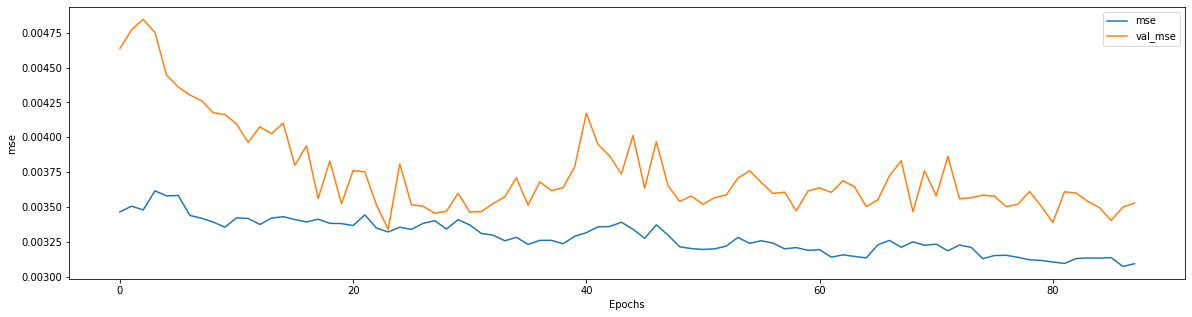

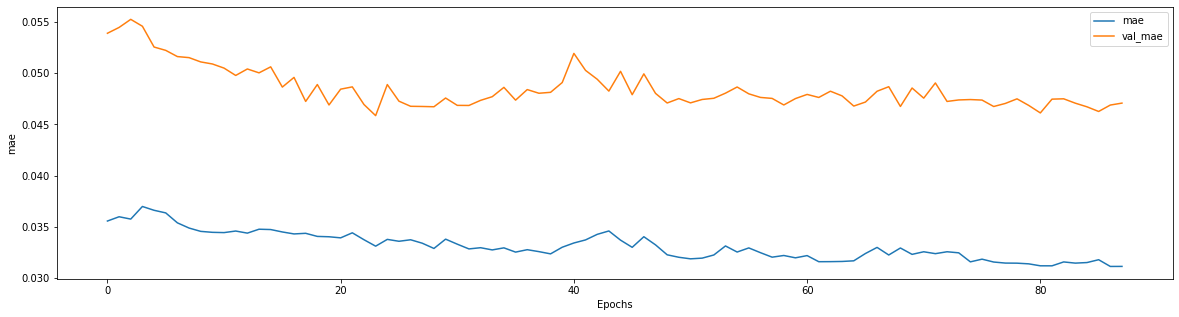

Generation.GIED1.Measurement.Apparent max abs error :  [1072.06259155]
Generation.GIED1.Measurement.Apparent huber loss :  354.12134
Generation.GIED1.Measurement.Apparent std :  4543.581426270653
Generation.GIED1.Measurement.Apparent diff std :  393.3100106052901


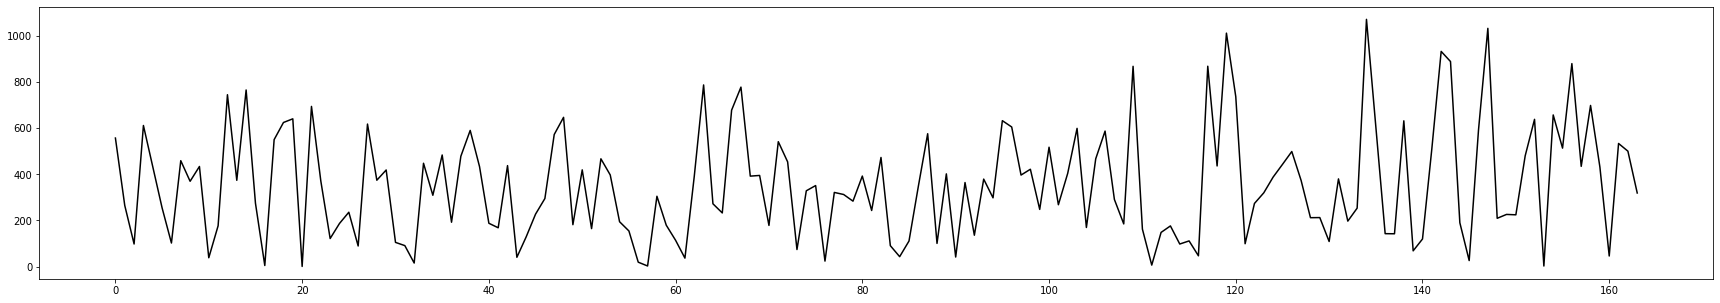

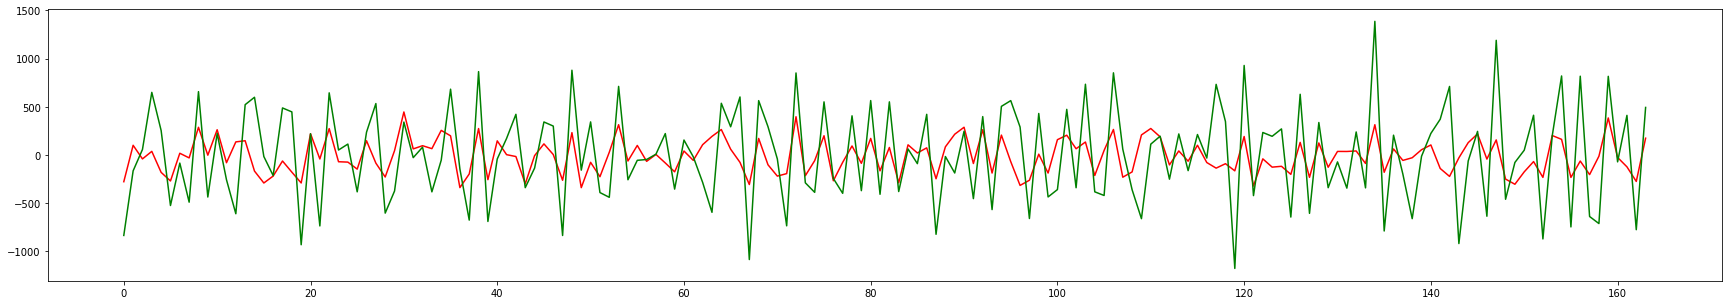

In [ ]:
for col in df_columns:
  print("*****************************************    training model for : " , col , "    ********************************************")
  df_new = df_concat.copy().reset_index(drop=True)
  # add col to last for prediction 
  df_new.insert(len(df_new.columns), col+'.org.diff1' , df_org_diff1[col+'.org.diff1'].reset_index(drop=True))
  
  train_df = df_new[0:int(n*0.85)].copy()
  val_df = df_new[int(n*0.85):int(n*0.95)].copy()
  test_df = df_new[int(n*0.95):].copy()

  print("train_df shape : ", train_df.shape)
  print("val_df shape : ", val_df.shape)
  print("test_df shape : ", test_df.shape)

  print("train_df first row 1 col 0:df_org.columns.size, -4:-1: ", train_df.iloc[0:1 , 0:df.columns.size].to_string(index=False, header=False), " ... ", train_df.iloc[0:1 , -4:-1].to_string(index=False, header=False))
  print("train_df first row 2 col 0:df_org.columns.size, -4:-1: ", train_df.iloc[1:2 , 0:df.columns.size].to_string(index=False, header=False), " ... ", train_df.iloc[1:2 , -4:-1].to_string(index=False, header=False))
  print("train_df row ", n_steps, " col -1 : ", train_df.iloc[n_steps-1:n_steps , -1:].to_string(index=False, header=False))
  print("train_df row ", n_steps+1, " col -1 : ", train_df.iloc[n_steps:n_steps+1 , -1:].to_string(index=False, header=False))


  train_cols = train_df.columns 

  x_scaler = preprocessing.MaxAbsScaler()
  y_scaler = preprocessing.MaxAbsScaler()
  x_scaler.fit(train_df[train_cols[ :-1]])
  y_scaler.fit(train_df[train_cols[-1]].values.reshape(-1, 1) )

  x_scaler_filename = path + col + ".x_scaler.save"
  joblib.dump(x_scaler, x_scaler_filename) 
  y_scaler_filename = path + col + ".y_scaler.save"
  joblib.dump(y_scaler, y_scaler_filename)

  train_df_scaled = train_df.copy()
  train_df_scaled[train_cols[ :-1]] = pd.DataFrame(x_scaler.transform(train_df[train_cols[ :-1]]))
  train_df_scaled[train_cols[-1]] = pd.DataFrame(y_scaler.transform(train_df[train_cols[-1]].values.reshape(-1, 1)))
  train_df_scaled = train_df_scaled.dropna()
  print("train_df_scaled shape : ", train_df_scaled.shape)

  val_df_scaled = train_df.copy()
  val_df_scaled[train_cols[ :-1]] = pd.DataFrame(x_scaler.transform(val_df[train_cols[ :-1]]))
  val_df_scaled[train_cols[-1]] = pd.DataFrame(y_scaler.transform(val_df[train_cols[-1]].values.reshape(-1, 1)))
  val_df_scaled = val_df_scaled.dropna()

  test_df_scaled = train_df.copy()
  test_df_scaled[ train_cols[ :-1] ] = pd.DataFrame(x_scaler.transform(test_df[train_cols[ :-1]]))
  test_df_scaled[ train_cols[-1] ] = pd.DataFrame(y_scaler.transform(test_df[train_cols[-1]].values.reshape(-1, 1)))
  test_df_scaled = test_df_scaled.dropna()

  X_train, y_train = split_sequences(train_df_scaled.values, n_steps)
  X_val, y_val = split_sequences(val_df_scaled.values, n_steps)
  X_test, y_test = split_sequences(test_df_scaled.values, n_steps)

  print("X_train shape: ", X_train.shape)
  print("X_val shape: ", X_val.shape)
  print("X_test shape: ", X_test.shape)


  print("X_train[0] shape : ", X_train[0].shape)
  print("X_train[0] : ", X_train[0][0][0] , " , " , X_train[0][0][1], "....." , X_train[0][0][-1])
  print("y_train[0] : ", y_train[0])
  print("X_train[1] : ", X_train[1][0][0] , " , " , X_train[1][0][1], "....." , X_train[1][0][-1])
  print("y_train[1] : ", y_train[1])

  # Prepare the training dataset
  train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
  train_dataset = train_dataset.shuffle(buffer_size=64).batch(256)

  # Prepare the validation dataset
  val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
  val_dataset = val_dataset.batch(64)
                                  
  lstm_model = tf.keras.models.Sequential()
  lstm_model.add(tf.keras.layers.Bidirectional( tf.keras.layers.LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.1, return_sequences=True)))
  lstm_model.add(tf.keras.layers.Bidirectional( tf.keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.05, return_sequences=True)))
  lstm_model.add(tf.keras.layers.Bidirectional( tf.keras.layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.04, return_sequences=True)))
  lstm_model.add(tf.keras.layers.Bidirectional( tf.keras.layers.LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.03, return_sequences=True)))
  lstm_model.add(tf.keras.layers.Bidirectional( tf.keras.layers.LSTM(16, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.02, return_sequences=True)))
  lstm_model.add(tf.keras.layers.Bidirectional( tf.keras.layers.LSTM(8, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.01)))
  lstm_model.add(tf.keras.layers.Dense(1))
  lstm_model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.MeanAbsoluteError(), #loss=tf.keras.losses.Huber(delta=1.35), 
                metrics=["mae", "mse", "msle", "logcosh", tf.keras.metrics.RootMeanSquaredError()])

  early_stoppong_callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', mode='min', patience=64)
  tqdm_callback = TqdmCallback(verbose=1)
  history = lstm_model.fit(train_dataset, validation_data=val_dataset, epochs=512, validation_steps=4, callbacks=[early_stoppong_callback, tqdm_callback ], verbose=0)
  # Plot the history
  plt.figure(figsize=(20,5))
  plot_history(history, 'mse')
  plt.figure(figsize=(20,5))
  plot_history(history, 'mae')

  y_pred=lstm_model.predict(X_test)

  y_test_inv = y_scaler.inverse_transform(y_test.reshape(-1, 1))
  y_pred_inv = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
  print(col + " max abs error : " , max(abs(y_pred_inv-y_test_inv)))
  print(col + " huber loss : ", h(y_test_inv, y_pred_inv).numpy())
  print(col + " std : ", df[col].describe().loc[['std']][0])
  print(col + " diff std : ", df_org_diff1[col+'.org.diff1'].describe().loc[['std']][0])

  plt.figure(figsize=(30,5))
  plt.plot(abs(y_pred_inv - y_test_inv), color='black')
  plt.show()
  plt.figure(figsize=(30,5))
  plt.plot(y_pred_inv, color='red')
  plt.plot(y_test_inv, color='green')
  plt.show()

  lstm_model.save(path + col + '.epic_lstm_model.h5')


*****************************************    evaluate model for :  EpicLog_Scenario_7_07_Nov_2018_14_40.csv  :  Generation.GIED1.Measurement.Apparent     ********************************************
Generation.GIED1.Measurement.Apparent  result  :  [0.03527846187353134, 0.03527846187353134, 0.0019420847529545426, 0.0007788497023284435, 0.000970086082816124, 0.044069088995456696]
Generation.GIED1.Measurement.Apparent  max abs error :  [1132.91613293]
Generation.GIED1.Measurement.Apparent  huber loss :  223.2381


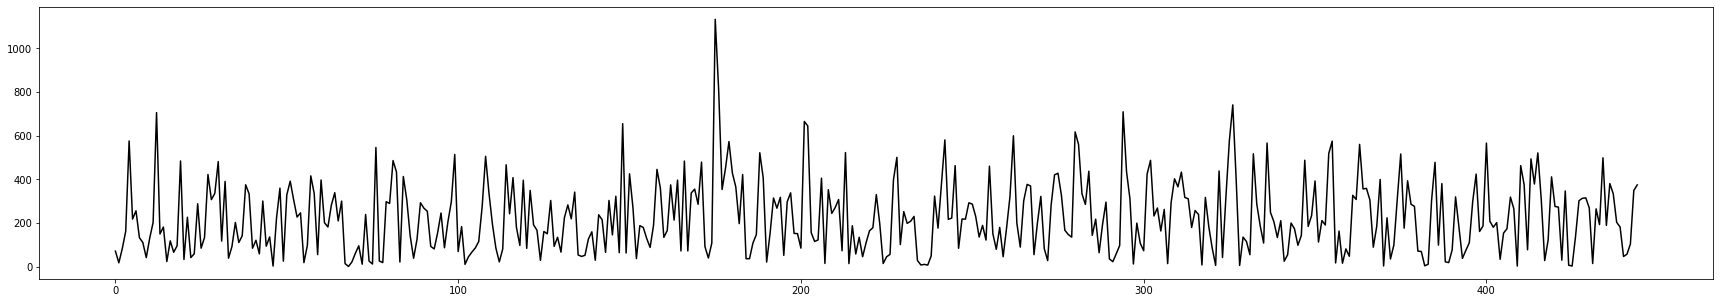

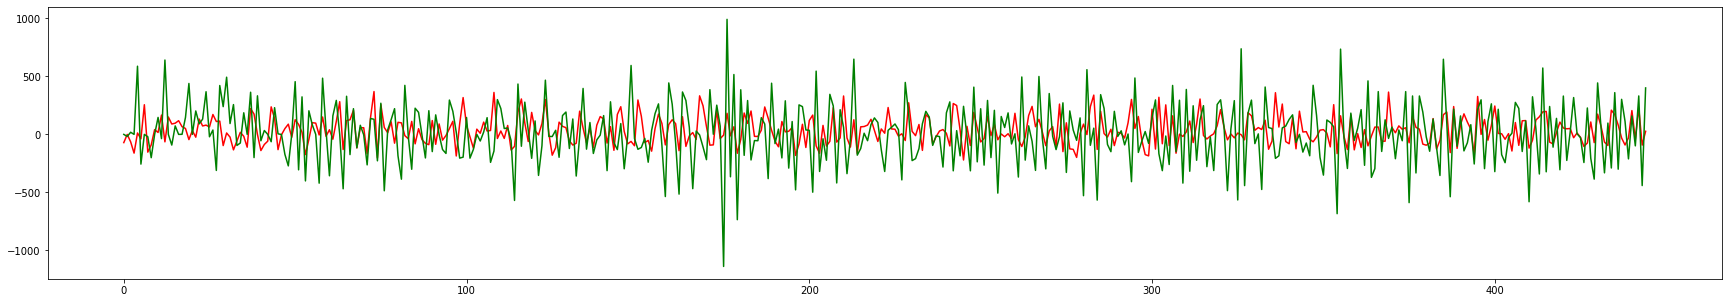

*****************************************    evaluate model for :  EpicLog_Scenario_8_07_Nov_2018_14_57.csv  :  Generation.GIED1.Measurement.Apparent     ********************************************
Generation.GIED1.Measurement.Apparent  result  :  [0.042621590197086334, 0.042621590197086334, 0.005275332368910313, 0.00238490360789001, 0.0024994416162371635, 0.07263147830963135]
Generation.GIED1.Measurement.Apparent  max abs error :  [6210.49240112]
Generation.GIED1.Measurement.Apparent  huber loss :  269.8086


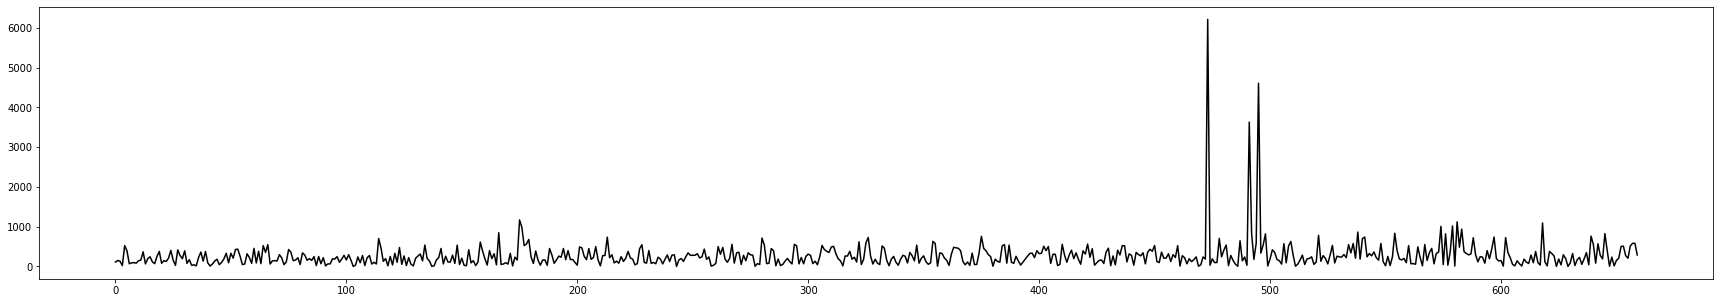

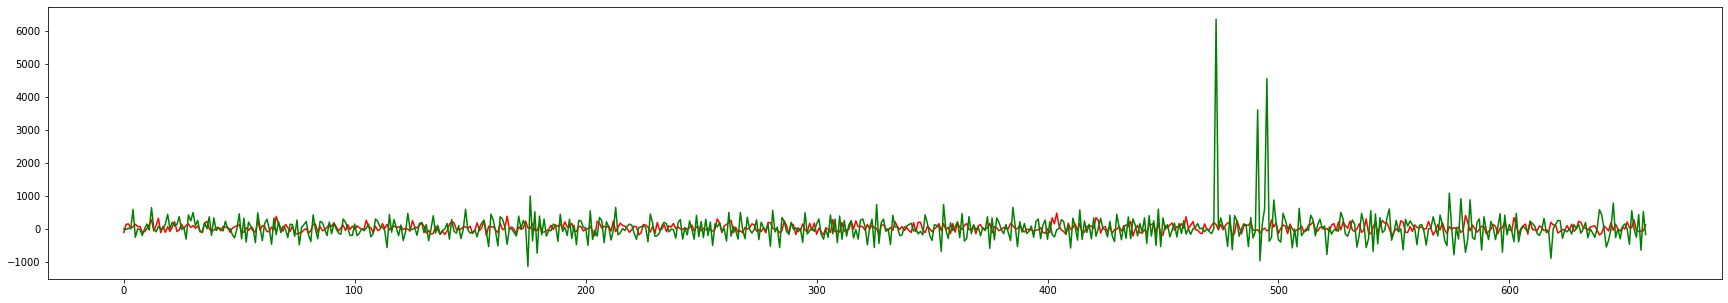

In [ ]:
url_prefix = "https://raw.githubusercontent.com/JayPBhatia/MastersProject/main/data/itrust/"
# 
epic_data_files = ["EpicLog_Scenario_7_07_Nov_2018_14_40.csv", 
                   "EpicLog_Scenario_8_07_Nov_2018_14_57.csv"]

for epic_file in epic_data_files:
  for col in df_columns:
    print("*****************************************    evaluate model for : " , epic_file , " : " , col , "    ********************************************")
    # move label col to last 
    df_eval = pd.read_csv(url_prefix+epic_file)

    df_eval = df_eval.select_dtypes(exclude=['object'])
    df_eval = df_eval.filter(regex='Generation.GIED1.Measurement')


    df_eval_new = add_features(df_eval)
    df_eval_new = df_eval_new.dropna()

    df_evel_org_diff1 = df.copy().diff(1).reset_index(drop=True)
    df_evel_org_diff1 = df_evel_org_diff1.add_suffix(".org.diff1")

    df_eval_new.insert(len(df_eval_new.columns), col + '.org.diff1', df_evel_org_diff1[col+'.org.diff1'])

    eval_cols = df_eval_new.columns 

    new_x_scaler = joblib.load(path + col + '.x_scaler.save')
    new_y_scaler = joblib.load(path+ col + '.y_scaler.save')
    new_lstm_model = tf.keras.models.load_model(path + col + '.epic_lstm_model.h5')
    df_eval_scaled = df_eval_new.copy()  
    df_eval_scaled[eval_cols[ :-1]] = pd.DataFrame(new_x_scaler.transform(df_eval_new[eval_cols[ :-1]]))
    df_eval_scaled[eval_cols[-1]] = pd.DataFrame(new_y_scaler.transform(df_eval_new[eval_cols[-1]].values.reshape(-1, 1)))
    df_eval_scaled = df_eval_scaled.dropna()
    X_eval, y_eval = split_sequences(df_eval_scaled.values, n_steps)
    result = new_lstm_model.evaluate(X_eval, y_eval, verbose=0)
    print(col ," result  : " , result)
    y_eval_pred = new_lstm_model.predict(X_eval)
    y_eval_inv = new_y_scaler.inverse_transform(y_eval.reshape(-1, 1))
    y_eval_pred_inv = new_y_scaler.inverse_transform(y_eval_pred.reshape(-1, 1))
    print(col, " max abs error : " , max(abs(y_eval_pred_inv - y_eval_inv)) )
    h = tf.keras.losses.Huber()
    print(col, " huber loss : " , h(y_eval_inv, y_eval_pred_inv).numpy())
    plt.figure(figsize=(30,5))
    plt.plot(abs(y_eval_pred_inv - y_eval_inv), color='black')
    plt.show()
    plt.figure(figsize=(30,5))
    plt.plot(y_eval_pred_inv, color='red')
    plt.plot(y_eval_inv, color='green')
    plt.show()

